In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import the dependencies
import os
from collections import Counter
from dotenv import load_dotenv
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN, HDBSCAN, KMeans
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import seaborn as sns
import sweetviz as sv

In [2]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get a reference to the data collection
data = db['Gov_Sys_Clustering_Data']

In [3]:
# Create a dataframe from the collection
gov_df = pd.DataFrame(list(data.find()))

In [4]:
# Drop the database id data and refresh the index
gov_df = gov_df.drop(['_id'], axis=1)
gov_df = gov_df.reset_index(drop=True)

# Create a new DataFrame for the country names.  Apply the country names as the new index for later merging.
country_df = pd.DataFrame()
country_df['country'] = gov_df['country']
country_df = country_df.set_index('country', drop=False)

# Set the DataFrame index to the country names to get them out of the way
gov_df = gov_df.set_index('country')
ori_df = gov_df.copy()
gov_df.head(5)

,government_type
country,
Albania,parliamentary republic
Algeria,presidential republic
Andorra,parliamentary democracy
Angola,presidential republic
Antigua and Barbuda,parliamentary democracy under a constitutional...


In [5]:
# Splitting the 'government_type' column's string entries on commas, and then chaining them
all_components = gov_df['government_type'].str.split(',').explode()

# Finding unique components
unique_components = all_components.unique()

# Optionally, convert to a list
unique_components_list = unique_components.tolist()

# Print the unique components
print(unique_components)

['parliamentary republic' 'presidential republic'
 'parliamentary democracy'
 'parliamentary democracy under a constitutional monarchy'
 'federal parliamentary democracy under a constitutional monarchy'
 'federal parliamentary republic' 'constitutional monarchy' 'dictatorship'
 'parliamentary democracy with limited self-government'
 'federal presidential republic' 'absolute monarchy or sultanate'
 'previously parliamentary republic'
 'parliamentary constitutional monarchy' 'communist party-led state'
 'semi-presidential republic' 'communist state' 'absolute monarchy'
 'presidential limited democracy' 'unitary parliamentary republic'
 'theocratic republic' 'in transition'
 'federal parliamentary constitutional monarchy'
 'mixed presidential-parliamentary system' 'federal republic'
 'semi-presidential federation' 'constitutional federal republic']


In [6]:
#create a list of component phrases to match
component_terms = ['absolute monarchy or sultanate','absolute monarchy','communist party-led state','communist state','constitutional federal republic','constitutional monarchy','dictatorship','federal parliamentary constitutional monarchy','federal parliamentary democracy under a constitutional monarchy','federal parliamentary republic','federal presidential republic','federal republic','in transition','mixed presidential-parliamentary system','parliamentary constitutional monarchy','parliamentary democracy under a constitutional monarchy','parliamentary democracy with limited self-government','parliamentary democracy','parliamentary republic','presidential limited democracy','presidential republic','previously parliamentary republic','semi-presidential federation','semi-presidential republic','theocratic republic','unitary parliamentary republic']

In [7]:
# Create a regex pattern from the list of components that will match across word boundaries
regex_pattern = r'(' + '|'.join(map(re.escape, sorted(component_terms, key=len, reverse=True))) + r')'

# Ensure the pattern is compiled for efficiency
compiled_pattern = re.compile(regex_pattern, flags=re.IGNORECASE)

# Function to match components using regex
def find_components(government_type, pattern):
    # Find all matches of the pattern within the government_type string
    matches = re.findall(pattern, government_type)
    return list(set(matches))  # return unique matches only

# Apply this function to the 'government_type' column
gov_df['components_matched'] = gov_df['government_type'].apply(lambda x: find_components(x, compiled_pattern))
gov_df

,government_type,components_matched
country,,
Albania,parliamentary republic,[parliamentary republic]
Algeria,presidential republic,[presidential republic]
Andorra,parliamentary democracy,[parliamentary democracy]
Angola,presidential republic,[presidential republic]
Antigua and Barbuda,parliamentary democracy under a constitutional...,[parliamentary democracy under a constitutiona...
...,...,...
Venezuela,federal presidential republic,[federal presidential republic]
Vietnam,communist state,[communist state]
Yemen,in transition,[in transition]


In [8]:
# print the system info and matches for comparison
for index, row in gov_df.iterrows():
    print(f"Row {index} - government_type: {row['government_type']}")
    print(f"Row {index} - components_matched: {row['components_matched']}\n")

Row Albania - government_type: parliamentary republic
Row Albania - components_matched: ['parliamentary republic']

Row Algeria - government_type: presidential republic
Row Algeria - components_matched: ['presidential republic']

Row Andorra - government_type: parliamentary democracy
Row Andorra - components_matched: ['parliamentary democracy']

Row Angola - government_type: presidential republic
Row Angola - components_matched: ['presidential republic']

Row Antigua and Barbuda - government_type: parliamentary democracy under a constitutional monarchy
Row Antigua and Barbuda - components_matched: ['parliamentary democracy under a constitutional monarchy']

Row Argentina - government_type: presidential republic
Row Argentina - components_matched: ['presidential republic']

Row Armenia - government_type: parliamentary democracy
Row Armenia - components_matched: ['parliamentary democracy']

Row Aruba - government_type: parliamentary democracy
Row Aruba - components_matched: ['parliamenta

In [9]:
# Since components won't repeat within a system type, using them as a single string per country makes sense
gov_df['components_str'] = gov_df['components_matched'].apply(' '.join)

# Define the stop words
stoppers = ['a','in','or','under','with']
# Apply the TfidfVectorizer to this column
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,4), stop_words=stoppers)
#, max_features=30
tfidf_matrix = tfidf_vectorizer.fit_transform(gov_df['components_str'])

# Transform the TF-IDF matrix to a DataFrame for clustering
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=gov_df.index)
tfidf_df.describe()

,absolute monarchy,absolute monarchy sultanate,communist party,communist party led,communist party led state,communist state,constitutional federal,constitutional federal republic,constitutional monarchy,democracy constitutional,...,presidential republic,previously parliamentary,previously parliamentary republic,self government,semi presidential,semi presidential federation,semi presidential republic,theocratic republic,unitary parliamentary,unitary parliamentary republic
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,...,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.024287,0.003325,0.002207,0.002207,0.002207,0.016216,0.003251,0.003251,0.089903,0.030206,...,0.377758,0.003649,0.003649,0.003738,0.051957,0.003497,0.050705,0.005405,0.003649,0.003649
std,0.149891,0.045230,0.030015,0.030015,0.030015,0.126649,0.044214,0.044214,0.224313,0.106813,...,0.463582,0.049627,0.049627,0.035856,0.176318,0.047561,0.177688,0.073521,0.049627,0.049627
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.615191,0.408248,0.408248,0.408248,1.000000,0.601371,0.601371,1.000000,0.431910,...,1.000000,0.675006,0.675006,0.345789,0.657734,0.646906,0.670027,1.000000,0.675006,0.675006


In [10]:
tfidf_df

,absolute monarchy,absolute monarchy sultanate,communist party,communist party led,communist party led state,communist state,constitutional federal,constitutional federal republic,constitutional monarchy,democracy constitutional,...,presidential republic,previously parliamentary,previously parliamentary republic,self government,semi presidential,semi presidential federation,semi presidential republic,theocratic republic,unitary parliamentary,unitary parliamentary republic
country,,,,,,,,,,,,,,,,,,,,,
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Antigua and Barbuda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.331436,0.43191,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.266746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vietnam,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yemen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Drop the text columns
gov_df = gov_df.drop(['government_type','components_matched','components_str'], axis=1)
gov_df

""
country
Albania
Algeria
Andorra
Angola
Antigua and Barbuda
...
Venezuela
Vietnam
Yemen


In [12]:
# Concatenate with original df
gov_df= pd.concat([gov_df, tfidf_df], axis=1)
gov_df

,absolute monarchy,absolute monarchy sultanate,communist party,communist party led,communist party led state,communist state,constitutional federal,constitutional federal republic,constitutional monarchy,democracy constitutional,...,presidential republic,previously parliamentary,previously parliamentary republic,self government,semi presidential,semi presidential federation,semi presidential republic,theocratic republic,unitary parliamentary,unitary parliamentary republic
country,,,,,,,,,,,,,,,,,,,,,
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Antigua and Barbuda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.331436,0.43191,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.266746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vietnam,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yemen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Collect the column labels so they can be reapplied after data scaling
tfidf_col_names = gov_df.columns.tolist()

In [14]:
# Standardize the data with MaxAbsScaler(). Using this scaler to maintain integrity of sparse encoded values.
scaler = MaxAbsScaler()

encode_scaled_nda = scaler.fit_transform(gov_df)
encode_scaled_nda

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
# Convert the scaled-encoded data back to a DataFrame (nda = Numpy Data Array)
scale_encode_df = pd.DataFrame(encode_scaled_nda, index=gov_df.index)

# Apply the column labels to ensure the data is properly identified
scale_encode_df = scale_encode_df.set_axis(tfidf_col_names, axis=1)
scale_encode_df

,absolute monarchy,absolute monarchy sultanate,communist party,communist party led,communist party led state,communist state,constitutional federal,constitutional federal republic,constitutional monarchy,democracy constitutional,...,presidential republic,previously parliamentary,previously parliamentary republic,self government,semi presidential,semi presidential federation,semi presidential republic,theocratic republic,unitary parliamentary,unitary parliamentary republic
country,,,,,,,,,,,,,,,,,,,,,
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Antigua and Barbuda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.331436,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.266746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vietnam,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yemen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Create an elbow curve to find the best value for K.
inertia = []
k= list(range(1,15))

# Calculate the inertia for a range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(scale_encode_df)
    inertia.append(km.inertia_)
    
# Create the elbow curve
elbow_data = {'k': k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)

elbow_df.hvplot(x='k', y='inertia', xticks=k, title='Elbow Curve')

:Curve   [k]   (inertia)

In [23]:
# define the model
KM_model = KMeans(n_clusters=4, random_state=42)

# Create a copy of the scale_encode_df for processing below
KM_df = scale_encode_df.copy()

# Fit the model - Make predictions
KM_pred = KM_model.fit_predict(KM_df)

# Add the predicted class columns
KM_df['gov_class'] = KM_model.labels_

In [24]:
# Concatenate with original df
KM_gov_df= pd.concat([country_df, KM_df], axis=1)
KM_gov_df

,country,absolute monarchy,absolute monarchy sultanate,communist party,communist party led,communist party led state,communist state,constitutional federal,constitutional federal republic,constitutional monarchy,...,previously parliamentary,previously parliamentary republic,self government,semi presidential,semi presidential federation,semi presidential republic,theocratic republic,unitary parliamentary,unitary parliamentary republic,gov_class
country,,,,,,,,,,,,,,,,,,,,,
Albania,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Algeria,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Andorra,Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Angola,Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Antigua and Barbuda,Antigua and Barbuda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.331436,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,Venezuela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Vietnam,Vietnam,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Yemen,Yemen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [25]:
# Generate a sweetviz report
gov_report = sv.analyze(KM_gov_df)

gov_report.show_html(filepath='gov_tfidf_weighting.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report gov_tfidf_weighting.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [26]:
gov_2_df = ori_df.copy()

In [27]:
# Apply the regex function to the 'government_type' column
gov_2_df['components_matched'] = gov_2_df['government_type'].apply(lambda x: find_components(x, compiled_pattern))
gov_2_df

,government_type,components_matched
country,,
Albania,parliamentary republic,[parliamentary republic]
Algeria,presidential republic,[presidential republic]
Andorra,parliamentary democracy,[parliamentary democracy]
Angola,presidential republic,[presidential republic]
Antigua and Barbuda,parliamentary democracy under a constitutional...,[parliamentary democracy under a constitutiona...
...,...,...
Venezuela,federal presidential republic,[federal presidential republic]
Vietnam,communist state,[communist state]
Yemen,in transition,[in transition]


In [28]:
# components_matched contains lists of matched gov component texts
components_df = gov_2_df['components_matched'].str.join('|').str.get_dummies('|')

# Concatenate with original df
encoded_df = pd.concat([gov_2_df, components_df], axis=1)

In [29]:
# Drop the text columns
encoded_df = encoded_df.drop(['government_type','components_matched'], axis=1)
encoded_df

,absolute monarchy,absolute monarchy or sultanate,communist party-led state,communist state,constitutional federal republic,constitutional monarchy,dictatorship,federal parliamentary constitutional monarchy,federal parliamentary democracy under a constitutional monarchy,federal parliamentary republic,...,parliamentary democracy under a constitutional monarchy,parliamentary democracy with limited self-government,parliamentary republic,presidential limited democracy,presidential republic,previously parliamentary republic,semi-presidential federation,semi-presidential republic,theocratic republic,unitary parliamentary republic
country,,,,,,,,,,,,,,,,,,,,,
Albania,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Algeria,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Andorra,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Angola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Antigua and Barbuda,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Vietnam,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Yemen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Collect the column labels so they can be reapplied after data scaling
encoded_col_names = encoded_df.columns.tolist()

In [31]:
# Standardize the data with MaxAbsScaler(). Using this scaler to maintain integrity of sparse encoded values.
scale2 = MaxAbsScaler()

encoded_scaled_nda = scale2.fit_transform(encoded_df)
encoded_scaled_nda

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
# Convert the scaled-encoded data back to a DataFrame (nda = Numpy Data Array)
s_e_df = pd.DataFrame(encoded_scaled_nda, index=encoded_df.index)

# Apply the column labels to ensure the data is properly identified
s_e_df = s_e_df.set_axis(encoded_col_names, axis=1)
s_e_df

,absolute monarchy,absolute monarchy or sultanate,communist party-led state,communist state,constitutional federal republic,constitutional monarchy,dictatorship,federal parliamentary constitutional monarchy,federal parliamentary democracy under a constitutional monarchy,federal parliamentary republic,...,parliamentary democracy under a constitutional monarchy,parliamentary democracy with limited self-government,parliamentary republic,presidential limited democracy,presidential republic,previously parliamentary republic,semi-presidential federation,semi-presidential republic,theocratic republic,unitary parliamentary republic
country,,,,,,,,,,,,,,,,,,,,,
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Antigua and Barbuda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vietnam,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yemen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Create an elbow curve to find the best value for K.
inertia = []
k= list(range(1,15))

# Create a copy of the scale_encode_df for processing below
KM_2_df = s_e_df.copy()

# Calculate the inertia for a range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(KM_2_df)
    inertia.append(km.inertia_)
    
# Create the elbow curve
elbow_data = {'k': k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)

elbow_df.hvplot(x='k', y='inertia', xticks=k, title='Elbow Curve')

:Curve   [k]   (inertia)

In [34]:
# define the model
KM_2_model = KMeans(n_clusters=5, random_state=42)

# Fit the model - Make predictions
KM_2_pred = KM_2_model.fit_predict(s_e_df)

# Add the predicted class columns
KM_2_df['gov_class'] = KM_2_model.labels_

# Concatenate with original df
KM2_df= pd.concat([country_df, KM_2_df], axis=1)

In [35]:
# Generate a sweetviz comparison report
#gov_2_report = sv.compare([KM_gov_df, "tfidf data"], [KM2_df, "get_dummies"])

#gov_2_report.show_html(layout='vertical')

In [36]:
# Generate a sweetviz analysis report
gov_2_report = sv.analyze(KM2_df)

gov_2_report.show_html(filepath='gov_KMEANS-get_dummies.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report gov_KMEANS-get_dummies.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [37]:
# define the model
KM_3_model = DBSCAN(n_jobs=-1)

# Create a copy of the scale_encode_df for processing below
KM_3_df = s_e_df.copy()

# Fit the model - Make predictions
KM_3_pred = KM_3_model.fit_predict(s_e_df)

# Add the predicted class columns
KM_3_df['gov_class'] = KM_3_model.labels_

# Concatenate with original df
KM3_df= pd.concat([country_df, KM_3_df], axis=1)

In [38]:
# Generate a sweetviz analysis report
gov_3_report = sv.analyze(KM3_df)

gov_3_report.show_html(filepath='gov_DBSCAN-get_dummies.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report gov_DBSCAN-get_dummies.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [39]:
# define the model
KM_4_model = HDBSCAN(n_jobs=-1)

# Create a copy of the scale_encode_df for processing below
KM_4_df = s_e_df.copy()

# Fit the model - Make predictions
KM_4_pred = KM_4_model.fit_predict(s_e_df)

# Add the predicted class columns
KM_4_df['gov_class'] = KM_4_model.labels_

# Concatenate with original df
KM4_df= pd.concat([country_df, KM_4_df], axis=1)

In [40]:
# Generate a sweetviz analysis report
gov_4_report = sv.analyze(KM4_df)

gov_4_report.show_html(filepath='gov_HDBSCAN-get_dummies.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report gov_HDBSCAN-get_dummies.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


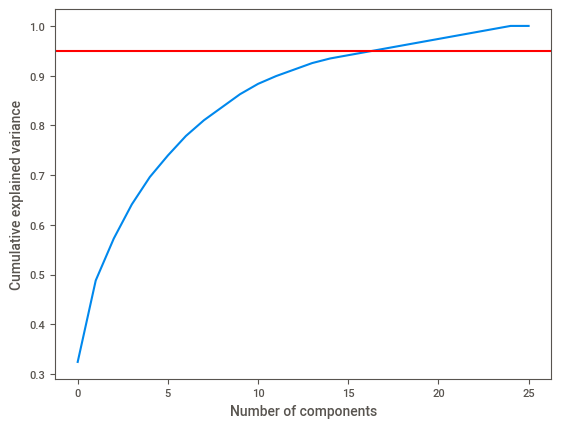

In [41]:
# Generate a cummulative variance ratio chart to determine the number of components to target for PCA.

# Create a copy of the scale_encode_df for processing below
PCA_df = s_e_df.copy()

pca = PCA().fit(PCA_df)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

In [47]:
# Using PCA to reduce dimension to the principal components.
n_comp=16
pca = PCA(n_components=n_comp)

# Get principal components for the gov data
gov_pca = pca.fit_transform(PCA_df)
gov_pca

array([[-6.67187938e-01,  5.88998587e-01,  4.00802125e-02, ...,
         1.65676510e-16, -3.85733920e-03,  1.87713840e-17],
       [ 6.76998736e-01,  1.50537853e-01,  1.73414782e-02, ...,
        -5.54182696e-17, -2.06984563e-03, -2.04469722e-17],
       [-2.23475485e-01, -3.07952542e-01, -1.28778420e-01, ...,
        -5.95369681e-17, -2.82770965e-02, -2.97287956e-17],
       ...,
       [-2.04698333e-01, -2.54496344e-01, -8.14483234e-02, ...,
        -4.47701623e-01, -2.23011784e-01,  1.19369449e-18],
       [ 6.76998736e-01,  1.50537853e-01,  1.73414782e-02, ...,
         1.65802669e-17, -2.06984563e-03, -2.30476330e-18],
       [ 6.76998736e-01,  1.50537853e-01,  1.73414782e-02, ...,
         1.59462515e-17, -2.06984563e-03, -2.71050543e-18]])

In [48]:
# Create a DataFrame with the principal components.
columnz =[]

for i in range(1,n_comp+1):
    columnz.append('Gov_PC'+str(i))

pcs_df = pd.DataFrame(data=gov_pca, columns=columnz, index=encoded_df.index)
pcs_df

,Gov_PC1,Gov_PC2,Gov_PC3,Gov_PC4,Gov_PC5,Gov_PC6,Gov_PC7,Gov_PC8,Gov_PC9,Gov_PC10,Gov_PC11,Gov_PC12,Gov_PC13,Gov_PC14,Gov_PC15,Gov_PC16
country,,,,,,,,,,,,,,,,
Albania,-0.667188,0.588999,0.040080,0.014185,-0.030562,0.009899,7.514030e-17,-0.013123,-5.121885e-17,-6.021754e-17,-0.005079,-0.006174,9.010302e-18,1.656765e-16,-0.003857,1.877138e-17
Algeria,0.676999,0.150538,0.017341,0.006496,-0.014616,0.004896,1.948152e-17,-0.006691,6.554045e-18,2.357833e-17,-0.002657,-0.003268,-4.945398e-18,-5.541827e-17,-0.002070,-2.044697e-17
Andorra,-0.223475,-0.307953,-0.128778,-0.077195,0.335632,-0.454148,-7.071068e-01,-0.339485,4.713486e-16,-6.375846e-16,-0.057272,-0.055813,8.413196e-17,-5.953697e-17,-0.028277,-2.972880e-17
Angola,0.676999,0.150538,0.017341,0.006496,-0.014616,0.004896,-7.719388e-17,-0.006691,1.414720e-17,1.138356e-17,-0.002657,-0.003268,1.004981e-17,-4.918098e-17,-0.002070,-5.623616e-18
Antigua and Barbuda,-0.246045,-0.389837,-0.307425,-0.692605,-0.514231,0.083084,1.345078e-16,-0.076627,6.153889e-17,3.051538e-16,-0.023691,-0.026465,-4.256102e-17,-3.349976e-17,-0.015096,1.770073e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,-0.213675,-0.278684,-0.099785,-0.053449,0.183772,-0.107286,-2.005953e-16,0.474689,7.071068e-01,-4.082483e-01,-0.196616,-0.125272,-2.536961e-18,2.277168e-16,-0.050190,-5.287637e-17
Vietnam,-0.209090,-0.266042,-0.089689,-0.046324,0.149868,-0.077637,1.851030e-15,0.215853,-1.940681e-16,-9.162474e-16,0.908093,-0.331634,2.267624e-16,-1.729847e-16,-0.081939,-8.799161e-17
Yemen,-0.204698,-0.254496,-0.081448,-0.040875,0.126525,-0.060828,-2.909211e-16,0.139686,3.853582e-16,-1.331268e-16,0.137203,0.512334,-6.828103e-01,-4.477016e-01,-0.223012,1.193694e-18


In [49]:
# Create an elbow curve to find the best value for K.
inertia = []
k= list(range(1,15))

# Create a copy of the scale_encode_df for processing below
KM_P1_df = pcs_df.copy()

# Calculate the inertia for a range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(KM_P1_df)
    inertia.append(km.inertia_)
    
# Create the elbow curve
elbow_data = {'k': k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)

elbow_df.hvplot(x='k', y='inertia', xticks=k, title='Elbow Curve')

:Curve   [k]   (inertia)

In [50]:
# define the model
KM_P1_model = KMeans(n_clusters=3, random_state=42)

# Fit the model - Make predictions
KM_P1_pred = KM_P1_model.fit_predict(KM_P1_df)

# Add the predicted class columns
KM_P1_df['gov_class'] = KM_P1_model.labels_

# Concatenate with original df
KM_P1_df= pd.concat([country_df, KM_P1_df], axis=1)

In [51]:
# Generate a sweetviz analysis report
gov_2_1_report = sv.analyze(KM_P1_df)

gov_2_1_report.show_html(filepath='gov_PCA-KMEANS-get_dummies.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report gov_PCA-KMEANS-get_dummies.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [52]:
# define the model
P2_model = DBSCAN(n_jobs=-1)

# Create a copy of the scale_encode_df for processing below
P2_df = pcs_df.copy()

# Fit the model - Make predictions
P2_pred = P2_model.fit_predict(P2_df)

# Add the predicted class columns
P2_df['gov_class'] = P2_model.labels_

# Concatenate with original df
DP2_df= pd.concat([country_df, P2_df], axis=1)

In [53]:
# Generate a sweetviz analysis report
gov_2_2_report = sv.analyze(DP2_df)

gov_2_2_report.show_html(filepath='gov_PCA-DBSCAN-get_dummies.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report gov_PCA-DBSCAN-get_dummies.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [54]:
# define the model
P3_model = HDBSCAN(n_jobs=-1)

# Create a copy of the scale_encode_df for processing below
P3_df = pcs_df.copy()

# Fit the model - Make predictions
P3_pred = P3_model.fit_predict(P3_df)

# Add the predicted class columns
P3_df['gov_class'] = P3_model.labels_

# Concatenate with original df
HP3_df= pd.concat([country_df, P3_df], axis=1)

In [55]:
# Generate a sweetviz analysis report
gov_2_3_report = sv.analyze(HP3_df)

gov_2_3_report.show_html(filepath='gov_PCA-HDBSCAN-get_dummies.html', layout='vertical')

                                             |                                             | [  0%]   00:00 ->…

Report gov_PCA-HDBSCAN-get_dummies.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
